In [12]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import functional as TF
import copy
import random
import numpy as np
from tqdm import tqdm

In [13]:
# -----------------------
# Utilities / Reproducibility
# -----------------------
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [14]:
# -----------------------
# Augmentations for MNIST (grayscale). Produces two augmented views.
# -----------------------
class TwoCropsTransform:
    """Generate two augmented views for BYOL (for MNIST)."""
    def __init__(self, base_transform):
        self.base = base_transform

    def __call__(self, x):
        return self.base(x), self.base(x)

mnist_aug = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # crop + resize back to 28
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, translate=(0.1,0.1), scale=(0.9,1.1), shear=10),
    transforms.ToTensor(),
    # MNIST is single channel; keep it single channel
    transforms.Normalize((0.1307,), (0.3081,))
])

# For linear eval and supervised baseline: standard transforms
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [15]:
# -----------------------
# Simple CNN encoder for MNIST
# Output: representation vector of dim rep_dim
# -----------------------
class ConvEncoder(nn.Module):
    def __init__(self, rep_dim=128):
        super().__init__()
        # small convnet
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1), # 28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7x7
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)), # 1x1
            nn.Flatten()
        )
        self.fc = nn.Linear(128, rep_dim)

    def forward(self, x):
        h = self.net(x)
        return self.fc(h)  # not normalized here

In [16]:
# -----------------------
# MLP projector and predictor
# -----------------------
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=256, out_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        return self.net(x)

In [17]:
# -----------------------
# BYOL model container (student and teacher networks)
# -----------------------
class BYOL:
    def __init__(self, encoder, projector_dim=64, pred_hidden=128, tau=0.99):
        # student
        self.student_encoder = encoder
        self.student_projector = MLP(in_dim=encoder.fc.out_features, hidden_dim=pred_hidden, out_dim=projector_dim)
        self.student_predictor = MLP(in_dim=projector_dim, hidden_dim=pred_hidden, out_dim=projector_dim)

        # teacher (EMA) - same architecture, but parameters updated by EMA
        self.teacher_encoder = copy.deepcopy(self.student_encoder)
        self.teacher_projector = copy.deepcopy(self.student_projector)

        # put teacher in eval mode and requires_grad = False
        self._set_requires_grad(self.teacher_encoder, False)
        self._set_requires_grad(self.teacher_projector, False)

        self.tau = tau

    @staticmethod
    def _set_requires_grad(model, req):
        for p in model.parameters():
            p.requires_grad = req

    def to(self, device):
        self.student_encoder.to(device)
        self.student_projector.to(device)
        self.student_predictor.to(device)
        self.teacher_encoder.to(device)
        self.teacher_projector.to(device)

    def student_forward(self, x):
        y = self.student_encoder(x)          # representation
        z = self.student_projector(y)       # projection
        p = self.student_predictor(z)       # prediction
        return y, z, p

    @torch.no_grad()
    def teacher_forward(self, x):
        y = self.teacher_encoder(x)
        z = self.teacher_projector(y)
        return y, z

    @torch.no_grad()
    def update_teacher(self):
        # EMA update: theta_t = tau * theta_t + (1 - tau) * theta_s
        for t_param, s_param in zip(self.teacher_encoder.parameters(), self.student_encoder.parameters()):
            t_param.data = self.tau * t_param.data + (1. - self.tau) * s_param.data
        for t_param, s_param in zip(self.teacher_projector.parameters(), self.student_projector.parameters()):
            t_param.data = self.tau * t_param.data + (1. - self.tau) * s_param.data

In [18]:
# -----------------------
# Loss: mean squared error between L2-normalized vectors
# Symmetrize over two views
# -----------------------
def byol_loss_fn(p, z_target):
    # p and z_target are batches of vectors
    p = F.normalize(p, dim=-1)
    z = F.normalize(z_target, dim=-1)
    return 2 - 2 * (p * z).sum(dim=-1)  # per-sample; equivalent to MSE of normalized vectors up to factor

In [19]:
# -----------------------
# Training loops
# -----------------------
def train_byol(byol: BYOL, dataloader, optimizer, device, epochs=20, tau=0.99, log_every=1):
    byol.tau = tau
    byol.to(device)
    byol.student_encoder.train()
    byol.student_projector.train()
    byol.student_predictor.train()
    # teacher in eval and no grad (we already froze its params)
    for epoch in range(1, epochs+1):
        pbar = tqdm(dataloader, desc=f"BYOL Pretrain Epoch {epoch}/{epochs}")
        running_loss = 0.0
        for (x1, x2), _ in pbar:
            x1 = x1.to(device)
            x2 = x2.to(device)
            # student forward on view1
            _, z1, p1 = byol.student_forward(x1)
            # teacher forward on view2 (stop grad)
            with torch.no_grad():
                _, z2_t = byol.teacher_forward(x2)
            # student forward on view2
            _, z2, p2 = byol.student_forward(x2)
            with torch.no_grad():
                _, z1_t = byol.teacher_forward(x1)

            # compute losses: BYOL symmetric loss
            loss1 = byol_loss_fn(p1, z2_t).mean()
            loss2 = byol_loss_fn(p2, z1_t).mean()
            loss = (loss1 + loss2) * 0.5

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # EMA update for teacher
            byol.update_teacher()

            running_loss += loss.item() * x1.size(0)
            pbar.set_postfix({'loss': f"{running_loss / ((pbar.n+1)*x1.size(0)):.4f}"})

        if epoch % log_every == 0:
            avg = running_loss / (len(dataloader.dataset))
            print(f"Epoch {epoch}: avg BYOL loss = {avg:.4f}")

In [20]:
def train_linear_eval(encoder, train_loader, test_loader, device, epochs=10, lr=1e-3):
    # Freeze encoder
    encoder.eval()
    for p in encoder.parameters():
        p.requires_grad = False
    # Linear head
    feat_dim = encoder.fc.out_features
    linear = nn.Linear(feat_dim, 10).to(device)
    opt = torch.optim.Adam(linear.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs+1):
        linear.train()
        running = 0
        for x, y in train_loader:
            x = x.to(device); y = y.to(device)
            with torch.no_grad():
                feats = encoder(x)
            logits = linear(feats)
            loss = criterion(logits, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            running += loss.item() * x.size(0)
        avg = running/len(train_loader.dataset)

        # eval
        acc = evaluate_encoder_linear(encoder, linear, test_loader, device)
        print(f"Linear Eval Epoch {epoch}: train_loss {avg:.4f}, test_acc {acc:.2f}%")
    return linear

In [21]:
def evaluate_encoder_linear(encoder, linear, test_loader, device):
    encoder.eval(); linear.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device); y = y.to(device)
            feats = encoder(x)
            logits = linear(feats)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total

In [22]:
def train_supervised_from_scratch(encoder, train_loader, test_loader, device, epochs=10, lr=1e-3):
    # train only linear head on top of randomly initialized encoder (or train encoder+linear? we implement both variants)
    encoder = copy.deepcopy(encoder).to(device)
    linear = nn.Linear(encoder.fc.out_features, 10).to(device)

    # Option A: train linear only (encoder frozen)
    for p in encoder.parameters():
        p.requires_grad = False

    opt = torch.optim.Adam(list(linear.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs+1):
        linear.train()
        running = 0
        for x, y in train_loader:
            x = x.to(device); y = y.to(device)
            with torch.no_grad():
                feats = encoder(x)
            logits = linear(feats)
            loss = criterion(logits, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            running += loss.item() * x.size(0)
        avg = running / len(train_loader.dataset)
        acc = evaluate_encoder_linear(encoder, linear, test_loader, device)
        print(f"Supervised (linear on rand init) Epoch {epoch}: train_loss {avg:.4f}, test_acc {acc:.2f}%")
    return linear

In [30]:
# -----------------------
# Data loaders
# For BYOL, dataset must return two augmented views and label (labels ignored during SSL)
# -----------------------
class MNISTTwoView(datasets.MNIST):
    def __init__(self, root, train, transform, download):
        super().__init__(root=root, train=train, transform=None, download=download)
        self.twotransform = transform

    def __getitem__(self, index):
        img, target = super().__getitem__(index)  # this returns PIL image for MNIST
        v1, v2 = self.twotransform(img)
        return (v1, v2), target

def make_dataloaders(batch_size_pretrain=256, batch_size_eval=256):
    pretrain_ds = MNISTTwoView(root='./data', train=True, transform=TwoCropsTransform(mnist_aug), download=True)
    pretrain_loader = DataLoader(pretrain_ds, batch_size=batch_size_pretrain, shuffle=True, num_workers=0, drop_last=True)

    train_ds = datasets.MNIST(root='./data', train=True, transform=eval_transform, download=True)
    test_ds = datasets.MNIST(root='./data', train=False, transform=eval_transform, download=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size_eval, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=batch_size_eval, shuffle=False, num_workers=0)

    return pretrain_loader, train_loader, test_loader


In [31]:
    # Hyperparameters you can tune
    pretrain_epochs = 20        # increase to 100+ for better results
    pretrain_batch = 256
    linear_epochs = 10
    tau_choices = [0.98, 0.995, 0.999]
    chosen_tau = 0.995

    pretrain_loader, train_loader, test_loader = make_dataloaders(batch_size_pretrain=pretrain_batch)

    # create encoder
    rep_dim = 128
    encoder = ConvEncoder(rep_dim=rep_dim)

    # BYOL setup
    byol = BYOL(encoder, projector_dim=64, pred_hidden=128, tau=chosen_tau)
    byol.to(device)

    # optimizer for student params (encoder, projector, predictor)
    student_params = list(byol.student_encoder.parameters()) + list(byol.student_projector.parameters()) + list(byol.student_predictor.parameters())
    optimizer = torch.optim.Adam(student_params, lr=1e-3, weight_decay=1e-6)

    print("Starting BYOL pretraining (MNIST)... Tau =", chosen_tau)
    train_byol(byol, pretrain_loader, optimizer, device, epochs=pretrain_epochs, tau=chosen_tau)

    # After pretraining: freeze student encoder and evaluate linear classifier
    print("\n--- Linear evaluation on frozen encoder (student encoder) ---")
    frozen_encoder = byol.student_encoder  # use the student encoder
    # Put encoder in eval mode
    frozen_encoder.eval()
    linear_head = train_linear_eval(frozen_encoder, train_loader, test_loader, device, epochs=linear_epochs, lr=1e-3)

    # Supervised baseline: linear head on top of RANDOMLY INITIALIZED encoder
    print("\n--- Supervised baseline: linear head on top of random init encoder ---")
    baseline_linear = train_supervised_from_scratch(encoder, train_loader, test_loader, device, epochs=linear_epochs, lr=1e-3)

    # Optionally: train full supervised end-to-end (encoder + linear) for comparison
    print("\n--- Supervised end-to-end training (encoder + linear) from scratch ---")
    # simple function to train end-to-end:
    def train_end2end(encoder_model, train_loader, test_loader, device, epochs=10, lr=1e-3):
        enc = copy.deepcopy(encoder_model).to(device)
        linear = nn.Linear(enc.fc.out_features, 10).to(device)
        opt = torch.optim.Adam(list(enc.parameters()) + list(linear.parameters()), lr=lr, weight_decay=1e-6)
        crit = nn.CrossEntropyLoss()
        for epoch in range(1, epochs+1):
            enc.train(); linear.train()
            running = 0
            for x, y in train_loader:
                x = x.to(device); y = y.to(device)
                feats = enc(x)
                logits = linear(feats)
                loss = crit(logits, y)
                opt.zero_grad(); loss.backward(); opt.step()
                running += loss.item() * x.size(0)
            avg = running / len(train_loader.dataset)
            # eval
            enc.eval(); linear.eval()
            acc = evaluate_encoder_linear(enc, linear, test_loader, device)
            print(f"End2End Epoch {epoch}: train_loss {avg:.4f}, test_acc {acc:.2f}%")
        return enc, linear

    e2e_epochs = 10
    _enc, _lin = train_end2end(encoder, train_loader, test_loader, device, epochs=e2e_epochs, lr=1e-3)

    print("Done. Compare test accuracies printed above for linear eval (BYOL), linear on random init, and end-to-end supervised.")

Starting BYOL pretraining (MNIST)... Tau = 0.995


BYOL Pretrain Epoch 1/20: 100%|██████████| 234/234 [01:19<00:00,  2.95it/s, loss=0.4066]


Epoch 1: avg BYOL loss = 0.4059


BYOL Pretrain Epoch 2/20: 100%|██████████| 234/234 [01:19<00:00,  2.93it/s, loss=0.1787]


Epoch 2: avg BYOL loss = 0.1784


BYOL Pretrain Epoch 3/20: 100%|██████████| 234/234 [01:20<00:00,  2.92it/s, loss=0.1284]


Epoch 3: avg BYOL loss = 0.1282


BYOL Pretrain Epoch 4/20: 100%|██████████| 234/234 [01:19<00:00,  2.96it/s, loss=0.1081]


Epoch 4: avg BYOL loss = 0.1079


BYOL Pretrain Epoch 5/20: 100%|██████████| 234/234 [01:18<00:00,  2.97it/s, loss=0.0960]


Epoch 5: avg BYOL loss = 0.0959


BYOL Pretrain Epoch 6/20: 100%|██████████| 234/234 [01:18<00:00,  2.98it/s, loss=0.0883]


Epoch 6: avg BYOL loss = 0.0882


BYOL Pretrain Epoch 7/20: 100%|██████████| 234/234 [01:18<00:00,  2.96it/s, loss=0.0832]


Epoch 7: avg BYOL loss = 0.0830


BYOL Pretrain Epoch 8/20: 100%|██████████| 234/234 [01:19<00:00,  2.94it/s, loss=0.0796]


Epoch 8: avg BYOL loss = 0.0795


BYOL Pretrain Epoch 9/20: 100%|██████████| 234/234 [01:18<00:00,  2.97it/s, loss=0.0782]


Epoch 9: avg BYOL loss = 0.0780


BYOL Pretrain Epoch 10/20: 100%|██████████| 234/234 [01:18<00:00,  2.98it/s, loss=0.0770]


Epoch 10: avg BYOL loss = 0.0769


BYOL Pretrain Epoch 11/20: 100%|██████████| 234/234 [01:18<00:00,  2.97it/s, loss=0.0767]


Epoch 11: avg BYOL loss = 0.0766


BYOL Pretrain Epoch 12/20: 100%|██████████| 234/234 [01:18<00:00,  2.98it/s, loss=0.0768]


Epoch 12: avg BYOL loss = 0.0767


BYOL Pretrain Epoch 13/20: 100%|██████████| 234/234 [01:18<00:00,  2.98it/s, loss=0.0767]


Epoch 13: avg BYOL loss = 0.0765


BYOL Pretrain Epoch 14/20: 100%|██████████| 234/234 [01:19<00:00,  2.96it/s, loss=0.0776]


Epoch 14: avg BYOL loss = 0.0774


BYOL Pretrain Epoch 15/20: 100%|██████████| 234/234 [01:18<00:00,  2.97it/s, loss=0.0773]


Epoch 15: avg BYOL loss = 0.0771


BYOL Pretrain Epoch 16/20: 100%|██████████| 234/234 [01:18<00:00,  2.97it/s, loss=0.0769]


Epoch 16: avg BYOL loss = 0.0768


BYOL Pretrain Epoch 17/20: 100%|██████████| 234/234 [01:18<00:00,  2.97it/s, loss=0.0770]


Epoch 17: avg BYOL loss = 0.0769


BYOL Pretrain Epoch 18/20: 100%|██████████| 234/234 [01:19<00:00,  2.95it/s, loss=0.0767]


Epoch 18: avg BYOL loss = 0.0766


BYOL Pretrain Epoch 19/20: 100%|██████████| 234/234 [01:19<00:00,  2.95it/s, loss=0.0774]


Epoch 19: avg BYOL loss = 0.0773


BYOL Pretrain Epoch 20/20: 100%|██████████| 234/234 [01:18<00:00,  2.97it/s, loss=0.0776]


Epoch 20: avg BYOL loss = 0.0775

--- Linear evaluation on frozen encoder (student encoder) ---
Linear Eval Epoch 1: train_loss 1.8641, test_acc 91.08%
Linear Eval Epoch 2: train_loss 1.2433, test_acc 93.74%
Linear Eval Epoch 3: train_loss 0.8804, test_acc 94.61%
Linear Eval Epoch 4: train_loss 0.6670, test_acc 94.77%
Linear Eval Epoch 5: train_loss 0.5342, test_acc 95.34%
Linear Eval Epoch 6: train_loss 0.4456, test_acc 95.57%
Linear Eval Epoch 7: train_loss 0.3832, test_acc 95.78%
Linear Eval Epoch 8: train_loss 0.3372, test_acc 95.92%
Linear Eval Epoch 9: train_loss 0.3020, test_acc 96.01%
Linear Eval Epoch 10: train_loss 0.2742, test_acc 96.25%

--- Supervised baseline: linear head on top of random init encoder ---
Supervised (linear on rand init) Epoch 1: train_loss 1.8870, test_acc 91.35%
Supervised (linear on rand init) Epoch 2: train_loss 1.2608, test_acc 93.77%
Supervised (linear on rand init) Epoch 3: train_loss 0.8923, test_acc 94.46%
Supervised (linear on rand init) Epoch 4

Computing t-SNE for 2000 samples...


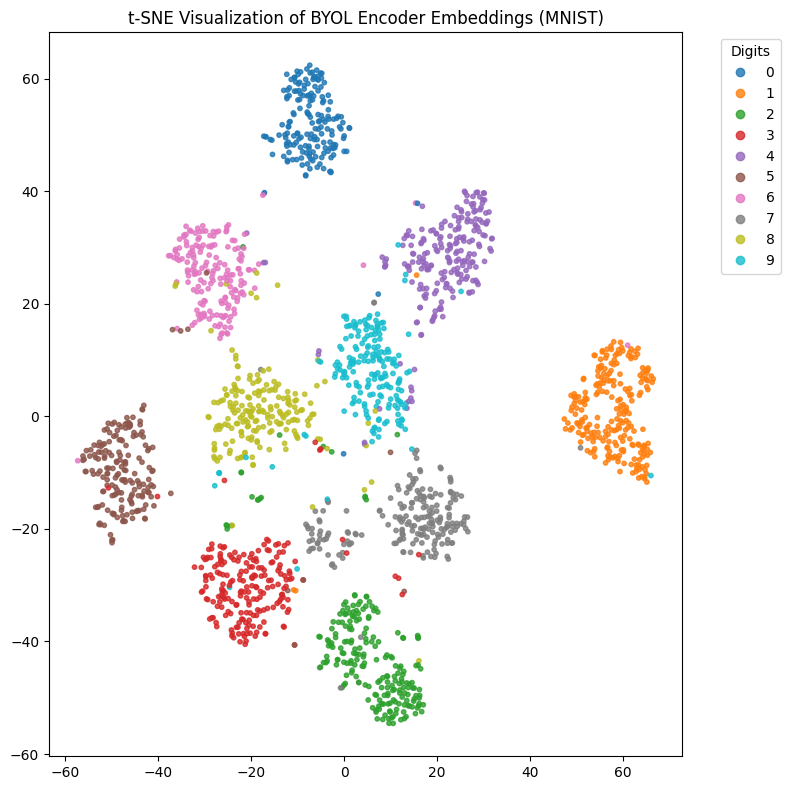

In [34]:
# t-SNE visualization of learned embeddings
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_embeddings_tsne(encoder, dataloader, device, n_samples=2000):
    encoder.eval()
    feats_list = []
    labels_list = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            feats = encoder(x)
            feats_list.append(feats.cpu())
            labels_list.append(y.cpu())
            if len(torch.cat(labels_list)) >= n_samples:
                break

    feats = torch.cat(feats_list)[:n_samples]
    labels = torch.cat(labels_list)[:n_samples]

    print(f"Computing t-SNE for {feats.shape[0]} samples...")
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    emb_2d = tsne.fit_transform(feats.numpy())

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap='tab10', s=10, alpha=0.8)
    plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("t-SNE Visualization of BYOL Encoder Embeddings (MNIST)")
    plt.tight_layout()
    plt.show()

# Example usage (visualize embeddings of pretrained BYOL encoder)
visualize_embeddings_tsne(frozen_encoder, test_loader, device)


Computing t-SNE for 2000 samples...


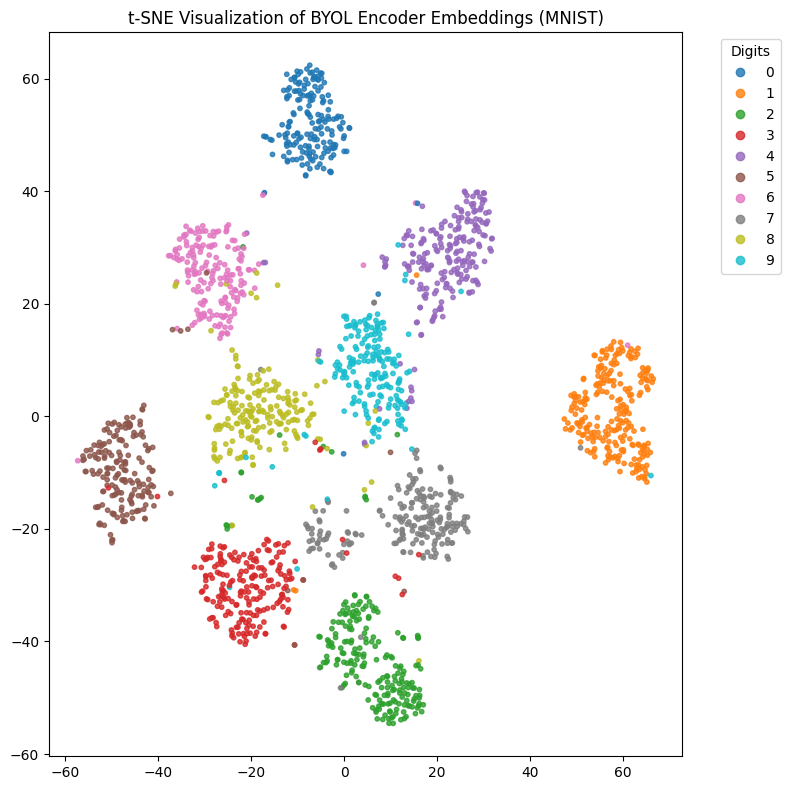

In [35]:
# t-SNE visualization of learned embeddings
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_embeddings_tsne(encoder, dataloader, device, n_samples=2000):
    encoder.eval()
    feats_list = []
    labels_list = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            feats = encoder(x)
            feats_list.append(feats.cpu())
            labels_list.append(y.cpu())
            if len(torch.cat(labels_list)) >= n_samples:
                break

    feats = torch.cat(feats_list)[:n_samples]
    labels = torch.cat(labels_list)[:n_samples]

    print(f"Computing t-SNE for {feats.shape[0]} samples...")
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200,
        max_iter=1000,       # заменено n_iter → max_iter
        random_state=42
    )
    emb_2d = tsne.fit_transform(feats.numpy())

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap='tab10', s=10, alpha=0.8)
    plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("t-SNE Visualization of BYOL Encoder Embeddings (MNIST)")
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_embeddings_tsne(frozen_encoder, test_loader, device)
